# Notebook to format data from "Machine learning enables improved runtime and precision for bio-loggers on seabirds", Korpela et al (2020).

Data was shared by Takuya Maekawa over email.

[Paper](https://www.nature.com/articles/s42003-020-01356-8)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import datetime
import tqdm

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/maekawa_gulls'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/maekawa_gulls'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
data_fp = os.path.join(raw_data_dir, 'raw_data.csv')
annotations_fp = os.path.join(raw_data_dir, 'labels.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 25
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'maekawa_gulls'

In [6]:
# Load data and annotations

data = pd.read_csv(data_fp)
annotations = pd.read_csv(annotations_fp)

data['datetime'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
annotations['stt_datetime'] = pd.to_datetime(annotations['stt_timestamp'], infer_datetime_format=True)
annotations['stp_datetime'] = pd.to_datetime(annotations['stp_timestamp'], infer_datetime_format=True)

In [7]:
# Specify individuals

individuals = sorted([int(x) for x in data['logger_id'].unique()])
data['individual_id'] = data['logger_id']

animal_tag_to_ind_id = {}
for tag in data['animal_tag'].unique():
    data_sub = data[data['animal_tag'] == tag]
    assert len(data_sub['individual_id'].unique()) == 1
    ind_id = data_sub['individual_id'].unique()[0]
    animal_tag_to_ind_id[tag] = ind_id
    
annotations['individual_id'] = annotations['animal_tag'].map(lambda x : animal_tag_to_ind_id[x])

In [8]:
# Specify behavior labels

beh_names = ['unknown', 
             'flying',
             'foraging',
             'stationary']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

In [9]:
# Populate data df with annotations

data['beh_label'] = 0

for individual in tqdm.tqdm(individuals):
    annotations_sub = annotations[annotations['individual_id'] == individual]
    for i, row in annotations_sub.iterrows():
        start = row['stt_datetime']
        end = row['stp_datetime']
        label = beh_str_to_int[row['activity']]
        data.loc[(data['individual_id'] == individual)&(data['datetime'] >= start) & (data['datetime'] <= end), 'beh_label'] = label

100%|██████████| 11/11 [00:21<00:00,  1.93s/it]


In [10]:
# Split into clips where there are time gaps

data['diff'] = data['datetime'].diff().dt.total_seconds()
data['diff'] = (data['diff'] != 0.04)
current_clip_id = -1
clip_id_to_individual_id = {}
data['clip_id'] = 0
for index in tqdm.tqdm(data['diff'][data['diff']].index):
    current_clip_id += data.loc[index, 'diff']
    clip_id_to_individual_id['clip_' + str(current_clip_id)] = int(data.loc[index, 'individual_id'])
    data.loc[index:, 'clip_id'] = current_clip_id
    
## check that each clip is associated with a unique individual

for i in data['clip_id'].unique():
    assert len(data[data['clip_id'] == i]['individual_id'].unique()) == 1
    
print("Each clip is associated with a unique individual")

## convention is that clip id's are strings
    
data['clip_id'] = data['clip_id'].map(lambda x : "clip_" + str(x))

100%|██████████| 174/174 [00:11<00:00, 14.78it/s]


Each clip is associated with a unique individual


In [11]:
# Omit short clips (fewer than 120 seconds)
# Recreate list of individuals, just in case any were dropped in this process

long_clips = list(data['clip_id'].value_counts()[data['clip_id'].value_counts() >= 120 * sr].keys())
data = data[data['clip_id'].isin(long_clips)].copy()

individuals = sorted([int(x) for x in data['individual_id'].unique()])
clip_ids = sorted([x for x in data['clip_id'].unique()])

tocheck = list(clip_id_to_individual_id)
for k in tocheck:
    if k not in clip_ids:
        clip_id_to_individual_id.pop(k)

In [12]:
## Save clip ids

dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['individual_ids'] = individuals
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [13]:
data['individual_id'].value_counts()

6     1688775
11    1671525
8     1481625
2      778525
3      732400
1      718300
4      668850
7      328200
9      273950
10     137425
5       60750
Name: individual_id, dtype: int64

In [14]:
# Set up data splits by individual

test_proportion = .34
val_proportion = .2
num_individuals = len(individuals)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(613) #611
test_individuals = list(rng.choice(individuals, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individuals.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

[1, 2, 3, 5, 6, 8]
[7, 11]
[1, 2, 3, 5, 6, 7, 8, 11]
[4, 9, 10]


In [15]:
# Set up clip ids by split

test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
dev_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

In [16]:
print("There are %d individuals" % len(individuals))

total_dur_sec = len(data) / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

There are 11 individuals
total duration is 341613.000000 seconds, i.e. 94.892500 hours


## Create dataset-level metadata

In [17]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [18]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [19]:
# We remove gravitational bias from each accel channel by applying a 
# butterworth filter with cutoff frequency of 0.3 Hz, then subtract the result

def smooth(series, smoothing_cutoff_freq):
    # smooth
    sos = signal.butter(10, smoothing_cutoff_freq, 'low', fs = sr, output = 'sos')
    series = signal.sosfilt(sos, series)
    return series

def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

In [20]:
# Save off individual clips in csv files

for clip_id in tqdm.tqdm(clip_ids):
    data_sub = data[data['clip_id'] == clip_id].copy()

    acc_data = np.array(data_sub[['acc_x', 'acc_y', 'acc_z']]) 
    static_acc_data = acc_data.copy()
    clip_dur_samples = np.shape(acc_data)[0]
    
    # correct for gravity
    for i in range(3): 
        to_correct = np.array(acc_data[:, i])
        static, corrected = extract_static(to_correct, 0.3)
        acc_data[:, i] = corrected
        static_acc_data[:, i] = static

    per_frame_annotations = np.array(data_sub[['individual_id', 'beh_label']])

    clip_data = np.concatenate([acc_data, static_acc_data, per_frame_annotations], axis = 1)

    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",")

100%|██████████| 24/24 [01:30<00:00,  3.76s/it]


## Check it all looks ok

In [21]:
clip_id = clip_ids[10]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')
#data = np.load(clip_data_fp)

In [22]:
np.shape(data)

(137850, 8)

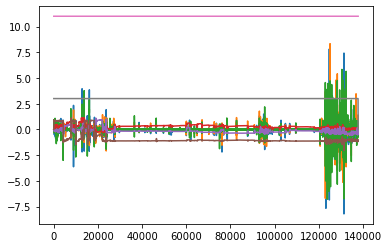

In [23]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, i])

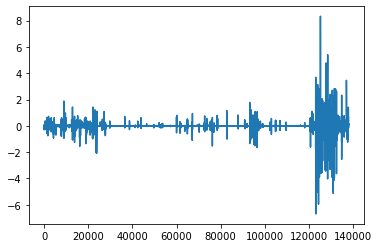

In [24]:
plt.plot(data[:,1])

## Plot Dataset Summary

In [25]:
# Count class representation

beh_names = dataset_metadata['label_names']
train_label_count = {name : 0 for name in beh_names}
val_label_count = {name : 0 for name in beh_names}
dev_label_count = {name : 0 for name in beh_names}
test_label_count = {name : 0 for name in beh_names}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        if clip_id in dataset_metadata['train_clip_ids']:
            train_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['val_clip_ids']:
            val_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['test_clip_ids']:
            test_label_count[name] += counts[key]

train_label_perc = {name : 0 for name in beh_names}
val_label_perc = {name : 0 for name in beh_names}
dev_label_perc = {name : 0 for name in beh_names}
test_label_perc = {name : 0 for name in beh_names}

for name in beh_names[1:]:
    train_label_perc[name] = train_label_count[name] / sum([train_label_count[j] for j in beh_names[1:]])
    val_label_perc[name] = val_label_count[name] / sum([val_label_count[j] for j in beh_names[1:]])
    dev_label_perc[name] = dev_label_count[name] / sum([dev_label_count[j] for j in beh_names[1:]])
    test_label_perc[name] = test_label_count[name] / sum([test_label_count[j] for j in beh_names[1:]])

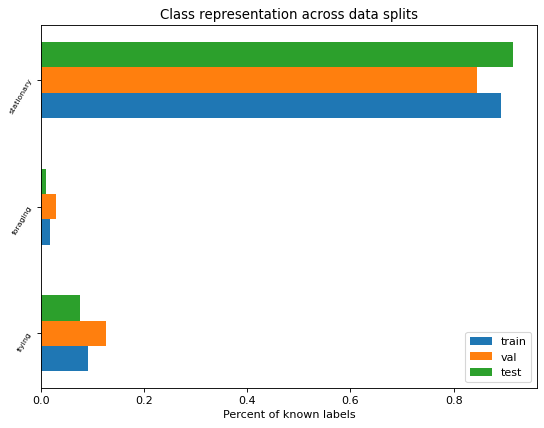

In [26]:
# Plot class representation

keys = np.arange(len(beh_names))[1:]
offset = 0.2
width = 0.2
plt.figure(figsize=(8, 6), dpi=80)

plt.barh(keys - offset, [train_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'train')
plt.barh(keys, [val_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'val')
plt.barh(keys + offset, [test_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'test')
plt.title("Class representation across data splits")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

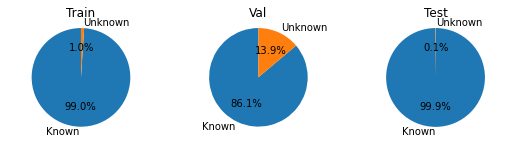

In [27]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,3, figsize = (9,2))
plt.title("blah")

ax[0].pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Train')

ax[1].pie(val_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Val')

ax[2].pie(test_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test')

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()
